# Using a machine learning model to predict the best scan positions for STEM-ptychography

This notebook demonstrates an advanced workflow for ptychographic reconstruction. Traditional ptychography often relies on scanning a dense grid of points, which can be time-consuming. This method employs a machine learning model to intelligently predict the most informative locations to scan next, aiming to reconstruct the atomic structure of a material with significantly fewer measurement points. As former results by M. Schloz et al. have demonstrated the most information can be gathered at positions where atoms lie, so the network was trained to predict atom positions.

The process is as follows:

1. Setup & Configuration: We'll import the necessary libraries and define the parameters for our simulation and reconstruction.

2. Data Simulation: We will simulate a set of 4D-STEM diffraction patterns from a known atomic structure (.cif file). This serves as our input data aswell as a ground truth we can later compare against. From the diffraction patterns Zernike moments are calculated. As A. Gladyshev et al. has shown they allow for a high degree of compression.

3. Creating predictions: A pre-trained neural network uses the Zernike moments at a subset of positions to predict a map of likely atom positions.

4. Results & Comparison: Finally, we'll visualize the model's predictions and compare them to the actual ground truth structure. The mode will give a weight to each possible scan position. We don't just use the highest rated position though. We employ a greedy algorithm that favours positions with a certain distance to each other. The most promising locations can then be measured for the final reconstruction.

These position could then be used in a reconstruction algorithm. Because this is done outside of python it is not in scope for this notebook. Instead we will fully focus on the machine learning model and its results.

***

### 1. Setup & Configuration

First, we import all the required libraries and modules. We'll also set up the configuration parameters for this reconstruction. The model was trained on expecting a certain electron energy, defocus etc. We also set the sparsity here. 

#### 1.1. Imports

This cell imports all necessary packages. Make sure you have all the necessary modules installed. The custom modules are assumed to be in their respective paths.

In [229]:
import nvidia_smi
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import sys
from tqdm.notebook import tqdm
from Reconstruction import *
import numpy as np
import matplotlib.pyplot as plt

# Set plotting style
plt.style.use('default')

#### 1.2. Configuration Parameters

Here you can easily modify the key parameters for the reconstruction. 

In [230]:
structure = "/data/scratch/haertelk/Masterarbeit/FullPixelGridML/structures/used/MoS2_hexagonal.cif"#"MarcelsEx"#"/data/scratch/haertelk/Masterarbeit/FullPixelGridML/structures/used/MoS2_hexagonal.cif" #"MarcelsEx"#"multiPillars"
model_checkpoint = "/data/scratch/haertelk/Masterarbeit/checkpoints/TrE_0111_0359_Z_TrE_230OSA_4to8s_hS512_enL5_50dA-50d_noH4_s1 copy/epoch=33-step=93704.ckpt"
print(f"Model: {model_checkpoint}")
sparseGridFactor = 4
print(f"Sparse grid factor: {sparseGridFactor}")
defocus = 50 # in Angstrom
print(f"defocus: {defocus} Angstrom")
makeNewFolder = True
print(  f"Make new folder: {makeNewFolder}")
scalerEnabled = True
print(f"Scaler enabled: {scalerEnabled}")
onlyPred = True
print(f"Only prediction: {onlyPred}")
nonPredictedBorderinCoordinates = 15
print(f"Non-predicted border in coordinates: {nonPredictedBorderinCoordinates}")
conv_angle_in_mrad = 33 # in mrad
print(f"Conversion angle in mrad: {conv_angle_in_mrad}")
energy= 60e3 # in eV
print(f"Energy: {energy} eV")
diameterBFD50Pixels = 18
print(f"Diameter of the BFD in pixels assuming a 50 pixel image: {diameterBFD50Pixels}")
start = (5,5)
print(f"Start position of simulation in coordinates: {start}")
end = (25,25)
print(f"End position of simulation in coordinates: {end}")
windowSizeInCoords = 15
print(f"Prediction window size in coordinates: {windowSizeInCoords}")
numberOfAtoms = 9
print(f"Number of atoms predicted for each window: {numberOfAtoms}")



Model: /data/scratch/haertelk/Masterarbeit/checkpoints/TrE_0111_0359_Z_TrE_230OSA_4to8s_hS512_enL5_50dA-50d_noH4_s1 copy/epoch=33-step=93704.ckpt
Sparse grid factor: 4
defocus: 50 Angstrom
Make new folder: True
Scaler enabled: True
Only prediction: True
Non-predicted border in coordinates: 15
Conversion angle in mrad: 33
Energy: 60000.0 eV
Diameter of the BFD in pixels assuming a 50 pixel image: 18
Start position of simulation in coordinates: (5, 5)
End position of simulation in coordinates: (25, 25)
Prediction window size in coordinates: 15
Number of atoms predicted for each window: 9


This part specifies the Zernike parametrisation.

In [231]:
numberOfOSAANSIMoments = 230
print(f"Number of OSAAN-Zernike moments: {numberOfOSAANSIMoments}")

Number of OSAAN-Zernike moments: 230


### 2. Data Simulation

Before we can reconstruct a structure, we need data. In this step, we'll simulate a 4D-STEM dataset from the provided .cif file. This gives us a measurement array (measurementArray) and the corresponding ground truth atomic structure (atomStruct). As an example this is the first diffraction pattern.

nameStruct: /data/scratch/haertelk/Masterarbeit/FullPixelGridML/structures/used/MoS2_hexagonal
CBEDDim: 161


Creating measurement array: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 10959.77it/s]


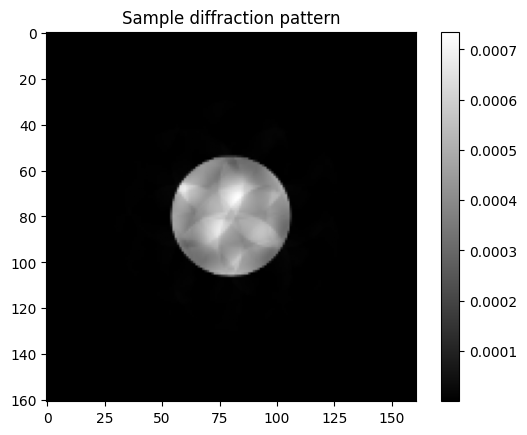

In [232]:
nameStruct, gridSampling, atomStruct, measurement_thick, potential_thick, CBEDDim, measurementArray, realPositions, allCoords = createMeasurementArray(energy, conv_angle_in_mrad, structure, start, end, defocus, onlyPred=onlyPred, device = "gpu") 

plt.imshow(measurement_thick.to_cpu().array[50,50,:,:], cmap='gray')
plt.title("Sample diffraction pattern")
plt.colorbar()
plt.show()

The bright field disk (BFD) diameter is calculated.

In [233]:
diameterBFDNotScaled = BFD_calculation(onlyPred, diameterBFD50Pixels, measurement_thick, measurementArray)
print(diameterBFDNotScaled)

imageDim Not Scaled to 50 Pixels: 161
57.96


Let's take a look at the structure we provided. It is an assortment of atom pillars randomly placed and with random elements. It is challenging in that it doesn't have any structure to it.

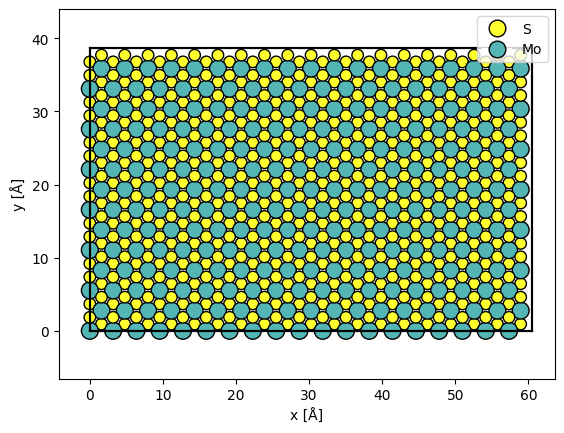

In [234]:
import abtem
abtem.show_atoms(atomStruct, legend = True);

For the predictions later on we only want to use a sparse grid of positions based of our sparse grid factor. The sparse grid factor describes how much fewer positions are used by the neural network than are used in the full STEM-ptychographic reconstruction. The scan step size for the full reconstrcution would be 0.2 Angstrom in each direction. So with a sparse grid factor of 8 this comes out to using one position every 1.6 Angstrom or in total terms every 64th position (= 1.56%). These are just the initial position. The neural network will then predict more position with a high amount of information densitity.

In [235]:
xMaxCNT, yMaxCNT = np.shape(measurement_thick.array)[:2] # type: ignore
chosenCoords2d = generate_sparse_grid(xMaxCNT, yMaxCNT, sparseGridFactor, twoD=True)
chosenCoords2dArray = np.array(chosenCoords2d)
chosenCoords = np.array(generate_sparse_grid(xMaxCNT, yMaxCNT, sparseGridFactor, twoD=False))

Visualizing which positions were chosen for scanning:

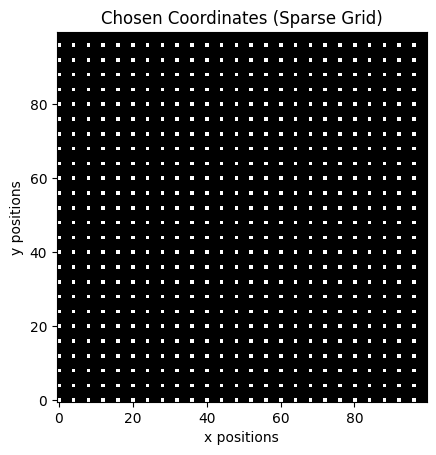

In [236]:
sparse_coordinate_img = np.zeros((xMaxCNT, yMaxCNT))
for x, y in chosenCoords2dArray:
    sparse_coordinate_img[x, y] = 1

plt.imshow(sparse_coordinate_img.T, origin='lower', cmap='gray')
plt.title("Chosen Coordinates (Sparse Grid)")
plt.xlabel("x positions")
plt.ylabel("y positions")
plt.show()

Next the actual simulations are performed and the atom position data from the atom structure are refined to be more usable. The diffraction patterns are also converted to Zernike moments. The number of Zernike moments was defined earlier. It has to be same as was used when training the model. 

In [237]:

difArrays = [[nameStruct, gridSampling, atomStruct, measurement_thick, potential_thick]]

RelLabelCSV, zernikeValuesSparse = saveAllPosDifPatterns(None, -1, None, diameterBFD50Pixels,
                                                        processID = 99999, silence = False,
                                                        maxPooling = 1, structure = "None",
                                                        fileWrite = False, difArrays = difArrays, nonPredictedBorderInA=0,
                                                        start = start, end = end, zernike=True, initialCoords=chosenCoords,
                                                        defocus = defocus, numberOfOSAANSIMoments=numberOfOSAANSIMoments, step_size = 200) # type: ignore



Total memory: 8192.0 MB, Free memory: 3418.0625 MB, Used memory: 4773.9375 MB
Calculating 0 to 200 of  625 coordinates
Total memory: 8192.0 MB, Free memory: 3418.0625 MB, Used memory: 4773.9375 MB
Calculating 200 to 400 of  625 coordinates
Total memory: 8192.0 MB, Free memory: 3418.0625 MB, Used memory: 4773.9375 MB
Calculating 400 to 600 of  625 coordinates
Total memory: 8192.0 MB, Free memory: 3418.0625 MB, Used memory: 4773.9375 MB
Calculating 600 to 625 of  625 coordinates


The Zernike moments were only calculated at the chosen sparse position. Now they are put back in a 2D grid of the same dimensions as the final image should be. This will simplify the following logic.

In [238]:
RelLabelCSV, zernikeValuesSparse = RelLabelCSV[0][1:], zernikeValuesSparse[0]
#RelLabelCSV contains the coordinates of the diffraction patterns of the atoms in the given structure
#zernikeValuesSparse contains the Zernike moments of the diffraction patterns at the sparse coordinates

zernikeValuesUnsparsed = torch.zeros((measurementArray.shape[0], measurementArray.shape[1], numberOfOSAANSIMoments), dtype=torch.float32)

for cnt, (x,y) in enumerate(tqdm(chosenCoords2dArray, desc="Filling zernike values unsparsed")):
    zernikeValuesUnsparsed[x, y, :] = torch.tensor(zernikeValuesSparse[cnt, :]).float()



Filling zernike values unsparsed: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:00<00:00, 46653.97it/s]


### Creating Predictions

To create the prediction the pretrained model is loaded in. It is trained on a defocus of -50 Angstrom and for sparse grid factors between 4 and 8.

In [239]:
model = None
torch.cuda.empty_cache() # clear GPU memory if used
model = TwoPartLightning.load_from_checkpoint(checkpoint_path = model_checkpoint,
                                                numberOfZernikeMoments = numberOfOSAANSIMoments,
                                                    numberOfAtoms = numberOfAtoms , num_layers = 5, hidden_size= 512, fc_num_layers = 3,
                                                    number_of_heads = 4
                                                    #,map_location="cpu"
                                                    )
model.eval().to(torch.device("cuda"));

number of heads: 4


This model can now be used to predict the most likely positions. This requires a few steps:

1. Scale and shift the Zernike moments. This is necessary because the model has been trained on Zernike moments which were normalized with the standard deviation and shifted around zero to make training more efficient.

2. The model only predicts in a 15x15 (3 A x 3 A) window. It takes in information from outside this window (limited by nonPredictedBorderinCoordinates) but it doesn't predict atom positions there. Because our sample is bigger than 3 A in each direction we move the model across the entire sample and predict at all possible positions. Every time a position is predicted it's score increases. We then sum up all scores from all position in order to get a final scoring over the entire sample.

In [240]:
#1. Scale and shift the Zernike moments
#load scaling factors

with open('Zernike/stdValues.csv', 'r') as file:
    line = file.readline()
    stdValues = [float(x.strip()) for x in line.split(',') if x.strip()]
    stdValuesArray = np.array(stdValues ) #TODO previously there was 1,1 as scaling for the coordinates
    stdValuesArray = np.delete(stdValuesArray, np.s_[numberOfOSAANSIMoments:-2])
    stdValuesArray = np.clip(stdValuesArray, a_min=1e-5, a_max=None) #avoid division by zero
    #stdValuesTorch = torch.tensor(stdValuesArray, dtype=torch.float32)

with open('Zernike/meanValues.csv', 'r') as file:
    line = file.readline()
    meanValues = [float(x.strip()) for x in line.split(',') if x.strip()]
    meanValuesArray = np.array(meanValues)  #TODO previously there was 0,0 as mean for the coordinates
    meanValuesArray = np.delete(meanValuesArray, np.s_[numberOfOSAANSIMoments:-2])
    #meanValuesTorch  : torch.Tensor = torch.tensor(meanValuesArray, dtype=torch.float32)


#TODO test for old. Above is the current implementation
# with open('Zernike/stdValues.csv', 'r') as file:
#     line = file.readline()
#     stdValues = [float(x.strip()) for x in line.split(',') if x.strip()]
#     stdValuesArray = np.array(stdValues[1:numberOfOSAANSIMoments] + [1,1,1]) #TODO previously there was 1,1 as scaling for the coordinates
#     # stdValuesArray = np.delete(stdValuesArray, np.s_[numberOfOSAANSIMoments:-2])
#     stdValuesArray = np.clip(stdValuesArray, a_min=1e-5, a_max=None) #avoid division by zero
#     stdValuesTorch = torch.tensor(stdValuesArray, dtype=torch.float)
# with open('Zernike/meanValues.csv', 'r') as file:
#     line = file.readline()
#     meanValues = [float(x.strip()) for x in line.split(',') if x.strip()]
#     meanValuesArray = np.array(meanValues[1:numberOfOSAANSIMoments] + [0,0,0])  #TODO previously there was 0,0 as mean for the coordinates
#     #meanValuesArray = np.delete(meanValuesArray, np.s_[numberOfOSAANSIMoments:-2])
#     meanValuesTorch  : torch.Tensor = torch.tensor(meanValuesArray, dtype=torch.float)
# with open('Zernike/stdValues.csv', 'r') as file:
#     line = file.readline()
#     stdValues = [float(x.strip()) for x in line.split(',') if x.strip()] #TODO es werden hier auch die Koordinaten mitgeladen, raus wenn im dataset raus
#     stdValuesArray = torch.tensor(stdValues[:numberOfOSAANSIMoments] + stdValues[-2:]) 
#     stdValuesArray = torch.clamp(stdValuesArray, min=1e-5, max=None) #avoid division by zero #TODO hier wird jetzt geclipt, im dataset neuerdings auch
# with open('Zernike/meanValues.csv', 'r') as file:
#     line = file.readline()
#     meanValues = [float(x.strip()) for x in line.split(',') if x.strip()]
#     meanValuesArray : torch.Tensor = torch.tensor(meanValues[:numberOfOSAANSIMoments] + meanValues[-2:])  #TODO es werden hier auch die Koordinaten mitgeladen, raus wenn im dataset raus

# with open('Zernike/stdValues.csv', 'r') as file:
#     line = file.readline()
#     stdValues = [float(x.strip()) for x in line.split(',') if x.strip()]
#     stdValuesArray = torch.tensor(stdValues[1:numberOfOSAANSIMoments + 1]) #TODO den oberen Part wieder nehmen, wenn bei datasets die todos erledigt sind
# with open('Zernike/meanValues.csv', 'r') as file:
#     line = file.readline()
#     meanValues = [float(x.strip()) for x in line.split(',') if x.strip()]
#     meanValuesArray : torch.Tensor = torch.tensor(meanValues[1:numberOfOSAANSIMoments + 1 ]) #TODO den oberen Part wieder nehmen, wenn bei datasets die todos erledigt sind
    


This is the loop that goes over all positions and adds up the predictions. The predicted positions are not perfectly on our pixel grid with step size 0.2. Therefore a kind of bilinaer smoothing is used. We don't need pixel perfect precision because atoms are larger than one scan step (0.2 A) in size. But it allows us to reduce noise. This takes around 50 seconds if a gpu is used or a few minutes on the cpu. 

In [241]:
 # loop over the all positions and apply the model to the data
Predictions = np.zeros((xMaxCNT, yMaxCNT))
PositionsToScanX = chosenCoords2dArray[:,0]
PositionsToScanY = chosenCoords2dArray[:,1]
predXAll = []
predYAll = []

localScansTotal = np.zeros((46,46))
ScansTotal = np.zeros_like(Predictions)

imageOrZernikeMoments = None
for indexX in tqdm(range(-windowSizeInCoords,Predictions.shape[0] + 1), desc  = "Going through all positions and predicting"):
    for indexY in range(-windowSizeInCoords,Predictions.shape[1] + 1):
        PositionsToScanXLocal = PositionsToScanX - indexX
        PositionsToScanYLocal = PositionsToScanY - indexY
        mask = (PositionsToScanXLocal >= -nonPredictedBorderinCoordinates) * (PositionsToScanYLocal >= - nonPredictedBorderinCoordinates) * (PositionsToScanXLocal <= (windowSizeInCoords + nonPredictedBorderinCoordinates)) * (PositionsToScanYLocal <= (windowSizeInCoords + nonPredictedBorderinCoordinates))
        numberOfScansInWindowPlusBorder = mask.sum()
        if numberOfScansInWindowPlusBorder <= 1:
            continue
        PositionsToScanXLocal = PositionsToScanXLocal[mask]
        PositionsToScanYLocal = PositionsToScanYLocal[mask]
        localScansTotal[PositionsToScanXLocal + nonPredictedBorderinCoordinates, PositionsToScanYLocal + nonPredictedBorderinCoordinates] += 1
        ScansTotal[indexX + PositionsToScanXLocal, indexY + PositionsToScanYLocal] += 1
        YCoordsLocal = torch.tensor(PositionsToScanYLocal)
        XCoordsLocal = torch.tensor(PositionsToScanXLocal)
        try: 
            imageOrZernikeMoments = zernikeValuesUnsparsed[(indexX + XCoordsLocal), (indexY + YCoordsLocal), :].reshape(-1, numberOfOSAANSIMoments)
        except IndexError as E:
            print("Error: Index out of bounds")
            print(f"XCoordsLocal: {XCoordsLocal}")
            print(f"YCoordsLocal: {YCoordsLocal}")
            print(f"indexX: {indexX}")
            print(f"indexY: {indexY}")
            raise Exception(E)

        imageOrZernikeMoments = np.concatenate((imageOrZernikeMoments, np.stack([XCoordsLocal, YCoordsLocal]).T), axis = 1)
        imageOrZernikeMoments = np.delete(imageOrZernikeMoments, np.s_[numberOfOSAANSIMoments:-2], axis=1)
        if scalerEnabled: imageOrZernikeMoments = (imageOrZernikeMoments - meanValuesArray[np.newaxis,:]) / stdValuesArray[np.newaxis,:] 
        
        #y and x are now correct
        imageOrZernikeMomentsCuda = torch.tensor(imageOrZernikeMoments, dtype=torch.float32).to(torch.device("cuda"))


        with torch.inference_mode():
            pred = model(imageOrZernikeMomentsCuda.unsqueeze(0))
            pred = pred.cpu().detach().numpy().reshape((1,-1,2))[0]
            


        for predXY in pred:
            for xCircle in range(-1,2):
                for yCircle in range(-1,2):                  
                    currentX = np.round(predXY[0]).astype(int)+xCircle
                    currentY = np.round(predXY[1]).astype(int)+yCircle
                    weight = 1 - np.min((np.square(predXY[0] - currentX) + np.square(predXY[1] - currentY), 1))
                    currentNonRelX = indexX + currentX
                    currentNonRelY = indexY + currentY
                    predXAll.append(currentX)
                    predYAll.append(currentY)
                    if currentNonRelX < 0 or currentNonRelX >= Predictions.shape[0] or currentNonRelY < 0 or currentNonRelY >= Predictions.shape[1]:
                       #skip if the predicted position is outside the sample
                       pass
                    else:

                        Predictions[currentNonRelX, currentNonRelY] += weight #The reconstruction is transposed. This is adjusted later when plotting.
#TODO! check against old jupyter nb. because there is no shift in there
#TODO also maybe it's shifted by -15 in the predictions? (Predictions are 15 lower than actual position)

Going through all positions and predicting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:47<00:00,  2.44it/s]


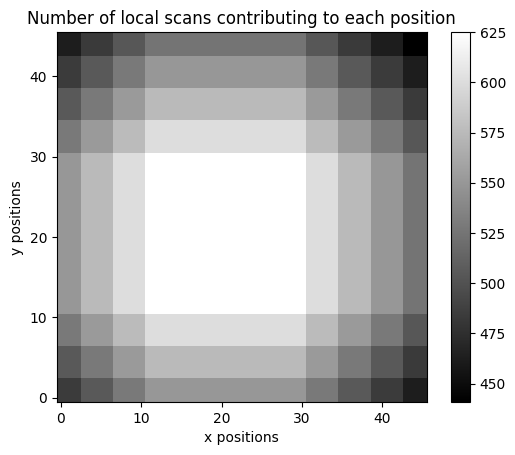

In [242]:
plt.imshow(localScansTotal.T, origin='lower', cmap='gray')
plt.title("Number of local scans contributing to each position")
plt.xlabel("x positions")
plt.ylabel("y positions")
plt.colorbar()
plt.show()

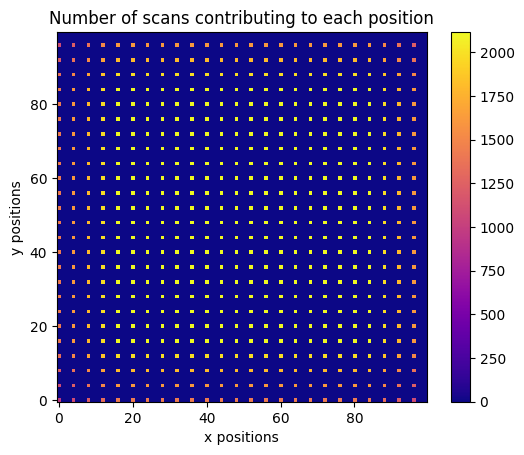

In [243]:
plt.imshow(ScansTotal.T, origin='lower', cmap='plasma')
plt.title("Number of scans contributing to each position")
plt.xlabel("x positions")
plt.ylabel("y positions")
plt.colorbar()
plt.show()

1 14 1 15


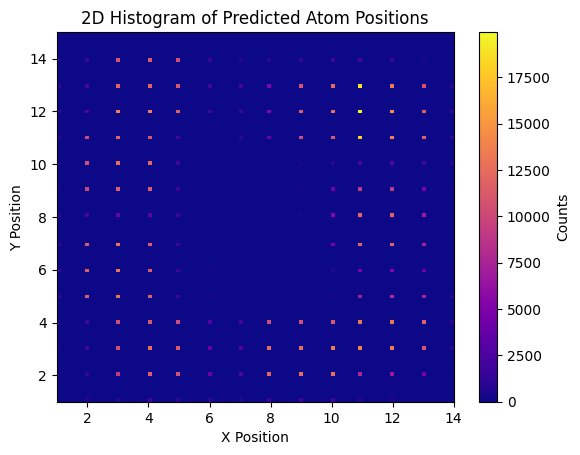

In [244]:
plt.hist2d(predXAll, predYAll, bins=100, range=[[min(predXAll), max(predXAll)], [min(predYAll), max(predYAll)]], cmap='plasma')
plt.colorbar(label='Counts')
plt.title('2D Histogram of Predicted Atom Positions')
plt.xlabel('X Position')
plt.ylabel('Y Position')
print(min(predXAll), max(predXAll), min(predYAll), max(predYAll))

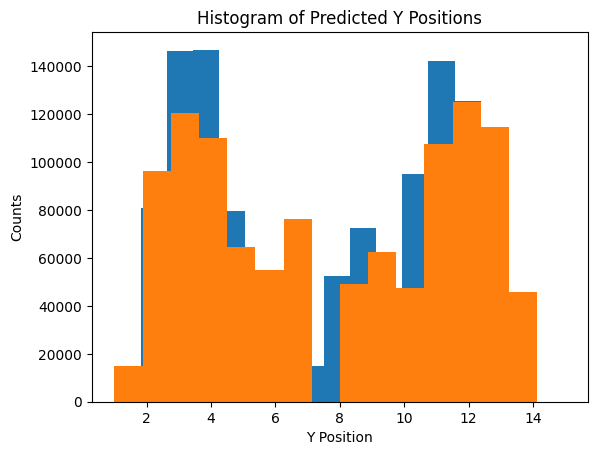

In [245]:
plt.hist(predXAll, bins=16)
plt.title('Histogram of Predicted X Positions')
plt.xlabel('X Position')
plt.ylabel('Counts')
plt.hist(predYAll, bins=16)
plt.title('Histogram of Predicted Y Positions')
plt.xlabel('Y Position')
plt.ylabel('Counts')
plt.show()

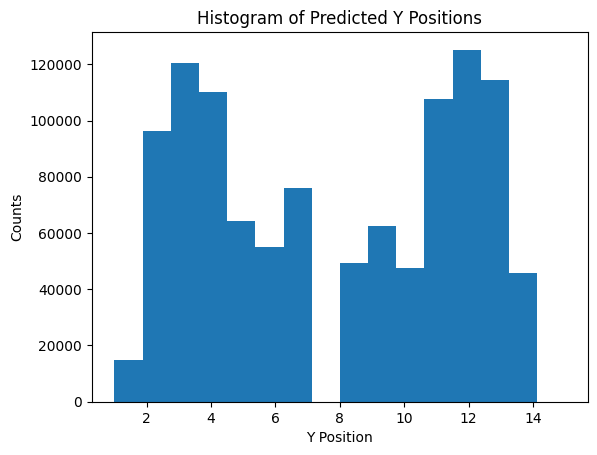

In [246]:
plt.hist(predYAll, bins=16)
plt.title('Histogram of Predicted Y Positions')
plt.xlabel('Y Position')
plt.ylabel('Counts')
plt.show()

It's time to look at the predictions. We only predict within an inner cutout (defined by start and end in the variables before) of the sample. This makes it harder for the model to correctly predict atom positions because even towards the edges there will be interference by atoms that are not included in the predictions. 

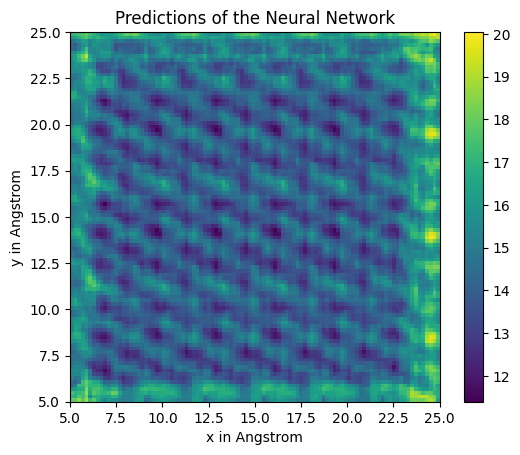

In [247]:
extent=  (start[0],end[0],start[1],end[1])
plt.imshow(Predictions.T, origin = "lower", interpolation="none", extent=extent)
plt.colorbar()
plt.xlabel("x in Angstrom")
plt.ylabel("y in Angstrom")
plt.title("Predictions of the Neural Network");

As we can see the predictions are dominated by a grid-like-pattern. This occurs at higher step sizes and increases the more empty space is present. In order to combat this we will calculate the predictions for empty space and substract them from the predictions. 

Going through all positions and predicting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 116/116 [00:47<00:00,  2.42it/s]


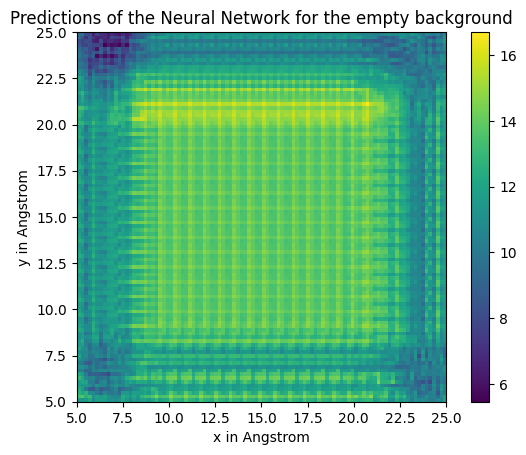

In [248]:
emptyBackgroundPredictions = createEmptyBackground(diameterBFD50Pixels, True, numberOfOSAANSIMoments, chosenCoords2dArray,
                          model, scalerEnabled, windowSizeInCoords, xMaxCNT, yMaxCNT,
                          nonPredictedBorderinCoordinates)

extent=  (start[0],end[0],start[1],end[1])
plt.imshow(emptyBackgroundPredictions.T, origin = "lower", interpolation="none", extent=extent)
plt.colorbar()
plt.xlabel("x in Angstrom")
plt.ylabel("y in Angstrom")
plt.title("Predictions of the Neural Network for the empty background")
plt.show()

In [249]:

def plotDif(x = 1):
    extent=  (start[0],end[0],start[1],end[1])
    plt.imshow(Predictions.T-emptyBackgroundPredictions.T*x, origin = "lower", interpolation="none", extent=extent)
    plt.colorbar()
    plt.xlabel("x in Angstrom")
    plt.ylabel("y in Angstrom")
    plt.title("Predictions of the Neural Network minus the empty background")
    plt.show()
    return x
w = interactive(plotDif,x=(0.0,5))
display(w)


interactive(children=(FloatSlider(value=1.0, description='x', max=5.0), Output()), _dom_classes=('widget-inter…

### 4. Results & Comparisons

While we can already see where atoms lie, it is necessary to calculate the ground truth so we have something to compare the predictions against. The information comes from the atom structure used in the simulation.

In [250]:
groundTruth = np.zeros((xMaxCNT, yMaxCNT))

groundTruthCalculator(RelLabelCSV, groundTruth, "")

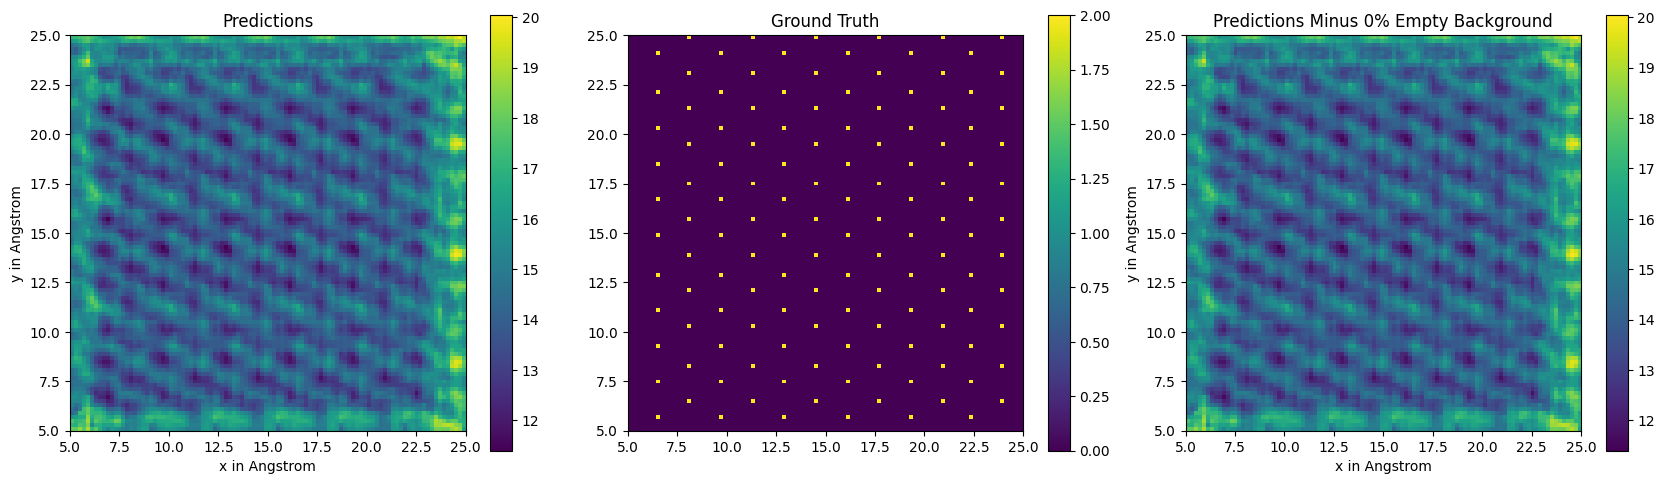

In [251]:
fig, axes = plt.subplots(1, 3, figsize=(17, 5))  # 1 row, 3 columns
r = 0#w.result
# Plot Predictions
im1 = axes[0].imshow(Predictions.T, origin="lower", interpolation="none", extent=extent)
axes[0].set_title("Predictions")
plt.colorbar(im1, ax=axes[0])
axes[0].set_xlabel("x in Angstrom")
axes[0].set_ylabel("y in Angstrom")
# Plot Ground Truth
im2 = axes[1].imshow(groundTruth.T, origin="lower", interpolation="none", extent=extent)
axes[1].set_title("Ground Truth")
plt.colorbar(im2, ax=axes[1])
plt.xlabel("x in Angstrom")
plt.ylabel("y in Angstrom")
plt.tight_layout()
im3 = axes[2].imshow((Predictions.T-emptyBackgroundPredictions.T*r), origin="lower", interpolation="none", extent=extent)
#Plot Predictions minus empty background
axes[2].set_title(f"Predictions Minus {r*100}% Empty Background")
plt.colorbar(im3, ax=axes[2])
plt.xlabel("x in Angstrom")
plt.ylabel("y in Angstrom")
plt.tight_layout()
plt.show()

In the following only the predictions minus the background are used. At a sparsity factor of 8 the atoms appear smeared out. But the general structure can still be seen. 

As mentioned in the introduction, we want to pick the best positions in the prediction for further scans. But this doesn't mean just using the highest rated positions because these usually are close together, resulting in many positions per atom. In order to discourage this we use a gaussian to suppress neighbouring positions. This algorithm gives each position a ranking.

In [252]:
"""
    Selects top-scoring pixels with spatial diversity using greedy selection with Gaussian suppression.

    Parameters:
        pred_map (np.ndarray): 2D prediction map.
        chosenCoords2d (np.ndarray): List of (x, y) coordinates already visited (will be masked).
        num_points (int): Number of top points to select.
        suppression_sigma (float): Sigma for Gaussian suppression kernel.
        suppression_strength (float): Multiplier for how much to suppress (1.0 = full subtraction).
    """
pred = Predictions.copy() - r* emptyBackgroundPredictions  # Subtract the empty background prediction
num_points=np.prod(pred.shape) # Total number of points in the prediction map
suppression_sigma=3.0
suppression_strength=5.0
# Mask already scanned positions
for x, y in chosenCoords2dArray:
    pred, exit = gaussian_suppressor(np.s_[x,y], suppression_sigma, suppression_strength, pred, radius=10)

indicesSortedByHighestPredicition = []
for _ in tqdm(range(num_points), desc="Greedy selection with Gaussian suppression on the prediction"):
    max_idx = np.unravel_index(np.argmax(pred), pred.shape)
    pred, exit = gaussian_suppressor(max_idx, suppression_sigma, suppression_strength, pred, radius = 10)
    if exit is True:
        break
    indicesSortedByHighestPredicition.append(max_idx)


predictions_scored_by_gaussian = np.zeros_like(Predictions)
for cnt, (x,y) in enumerate(indicesSortedByHighestPredicition):
    predictions_scored_by_gaussian[x,y] = len(indicesSortedByHighestPredicition) - cnt


Greedy selection with Gaussian suppression on the prediction:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 9375/10000 [00:01<00:00, 5355.20it/s]


The score of the position now looks like this. It looks more noisy but this is a good thing. It appears like that way because similar scores for neighbouring positions are less likely. We can see the black areas surrounding the predicted atom positions. The latter are the brightest meaning they have the highest score.

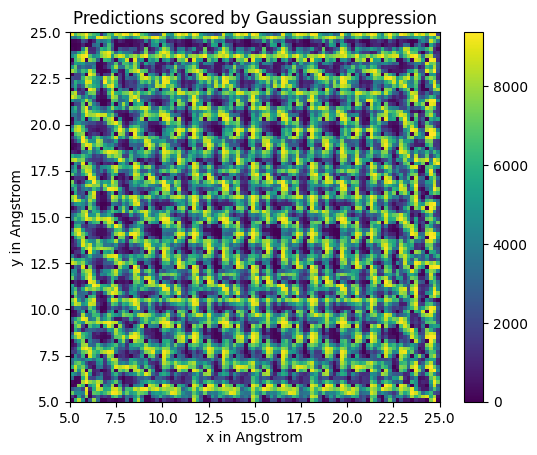

In [253]:
plt.imshow(predictions_scored_by_gaussian.T, origin='lower', extent=extent)
plt.title("Predictions scored by Gaussian suppression")
plt.xlabel("x in Angstrom")
plt.ylabel("y in Angstrom")
plt.colorbar()
plt.show()

Now we choose a varying amount of scan position based on the ranking above. We start of with 50% of all scan positions and go down to 4%. The minimum amount is determined by the initial coarse scan step size. With a sparse step size of 8 this amounts to roughly 1/(8*8) = 1.56%. In practice this is higher because the size of sample is not a multiple of 8. We then plot in yellow the chosen scan position for this ratio (including the sparse grid from the beginning). We also plot on the right the ground truth overlaid on these chosen positions. As we can see, with fewer chosen scan positions the atom position remain.

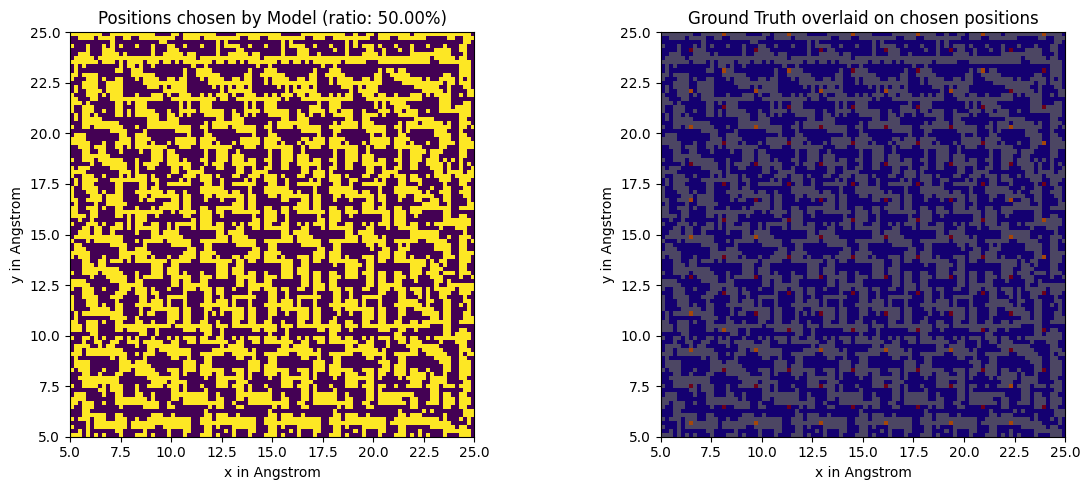

Number of positions chosen: 4375
Number of initial scan positions: 625
Total number of positions: 5000
Number of positions with atoms in them in ground truth: 132
Median number of scans per atom: 2.00
Ratio of scans (suggested + initial) that are close to an atom position: 5.84%


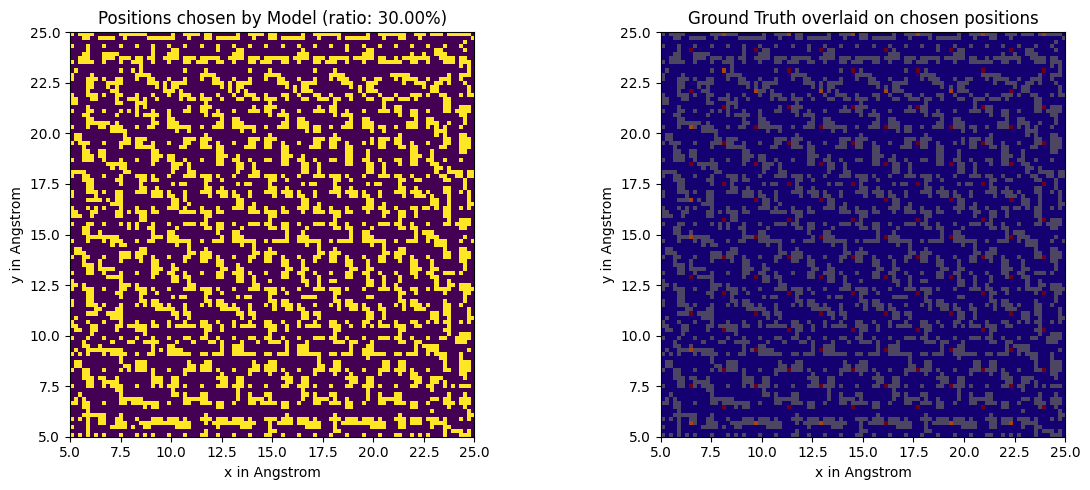

Number of positions chosen: 2375
Number of initial scan positions: 625
Total number of positions: 3000
Number of positions with atoms in them in ground truth: 132
Median number of scans per atom: 1.00
Ratio of scans (suggested + initial) that are close to an atom position: 4.37%


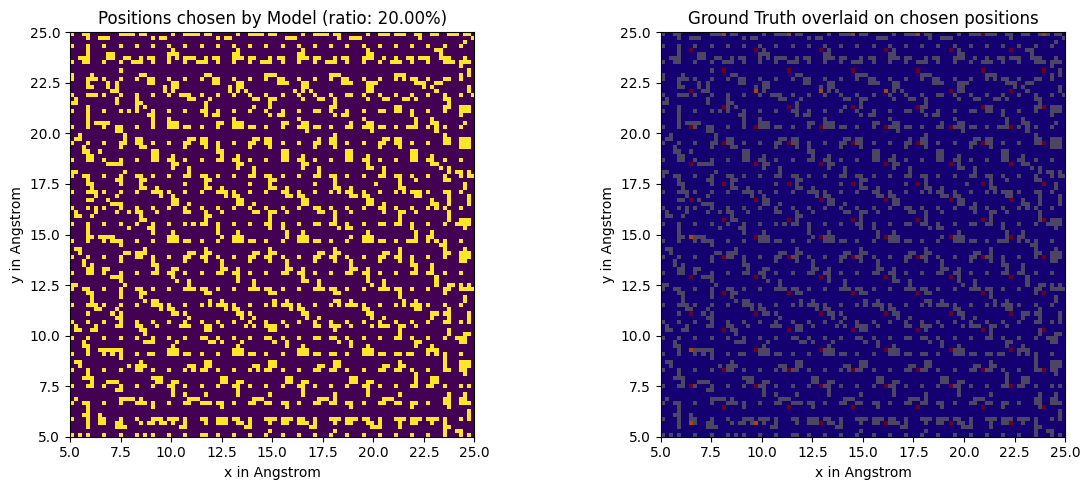

Number of positions chosen: 1375
Number of initial scan positions: 625
Total number of positions: 2000
Number of positions with atoms in them in ground truth: 132
Median number of scans per atom: 0.00
Ratio of scans (suggested + initial) that are close to an atom position: 4.10%


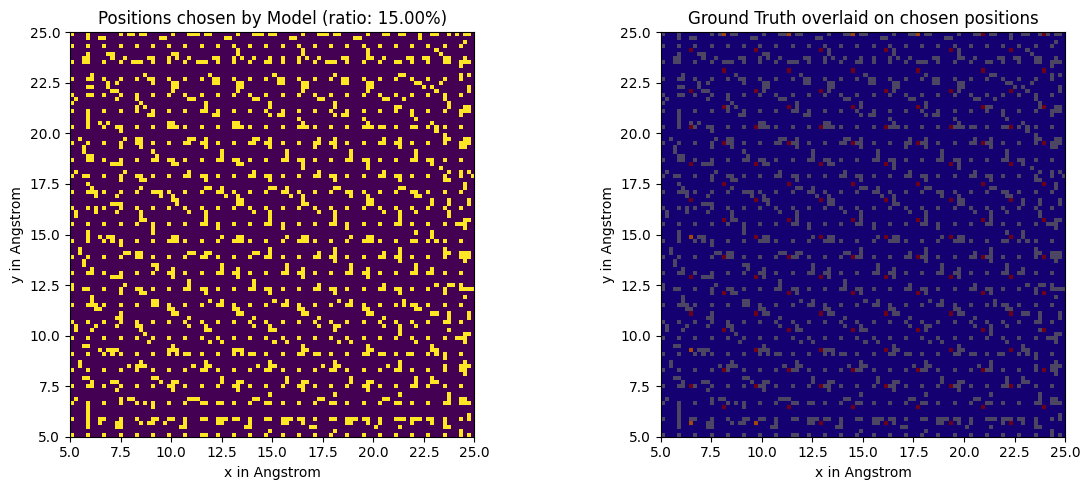

Number of positions chosen: 875
Number of initial scan positions: 625
Total number of positions: 1500
Number of positions with atoms in them in ground truth: 132
Median number of scans per atom: 0.00
Ratio of scans (suggested + initial) that are close to an atom position: 3.60%


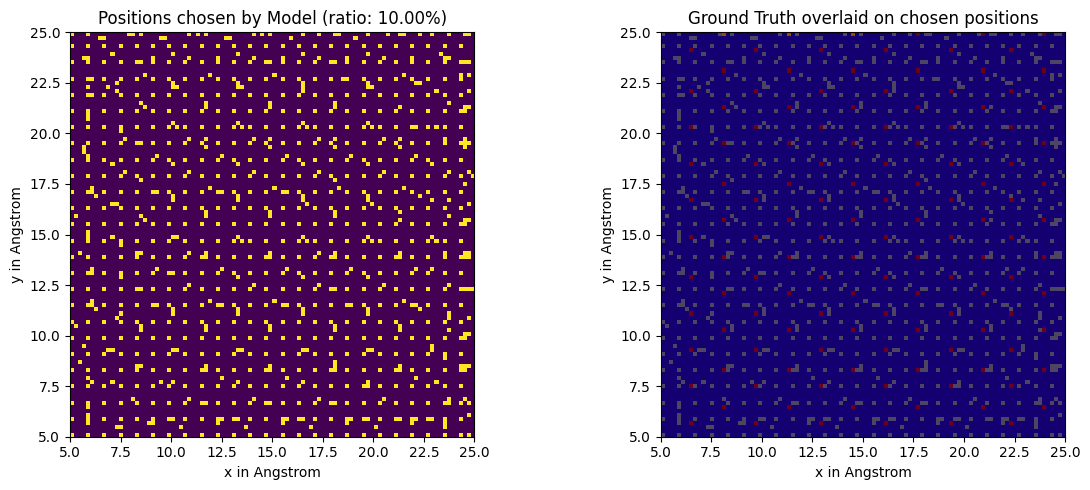

Number of positions chosen: 375
Number of initial scan positions: 625
Total number of positions: 1000
Number of positions with atoms in them in ground truth: 132
Median number of scans per atom: 0.00
Ratio of scans (suggested + initial) that are close to an atom position: 3.50%


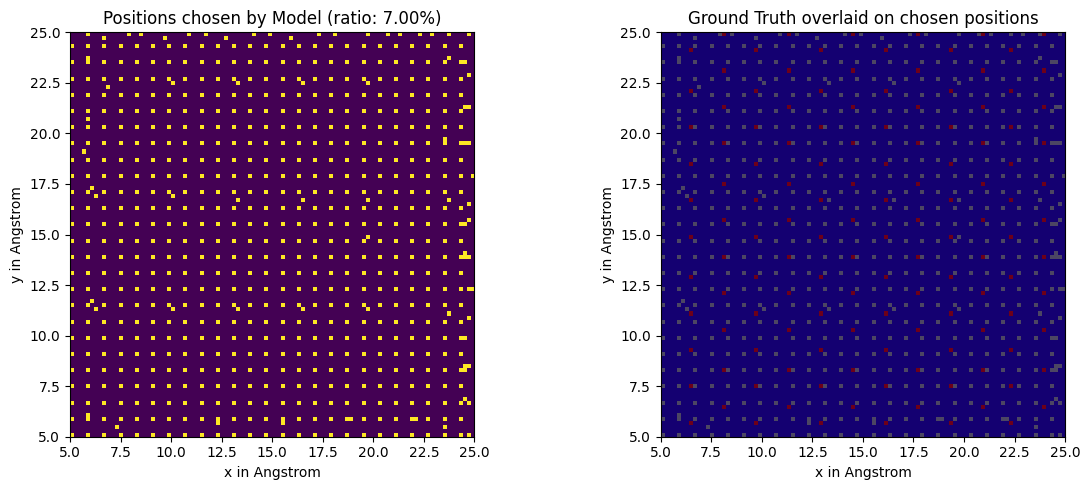

Number of positions chosen: 75
Number of initial scan positions: 625
Total number of positions: 700
Number of positions with atoms in them in ground truth: 132
Median number of scans per atom: 0.00
Ratio of scans (suggested + initial) that are close to an atom position: 4.00%


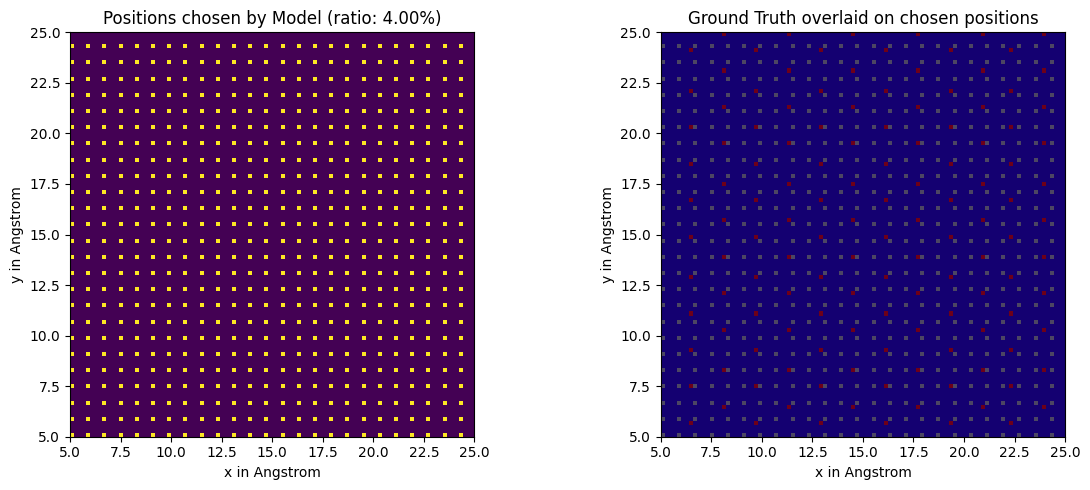

Number of positions chosen: 0
Number of initial scan positions: 625
Total number of positions: 625
Number of positions with atoms in them in ground truth: 132
Median number of scans per atom: 0.00
Ratio of scans (suggested + initial) that are close to an atom position: 4.00%


In [254]:
median_scans_per_atom_with_model = []
useful_scans_with_model = []
std_scans_per_atom_with_model = []
scans_per_atom_with_model = []

acceptable_distance = 1 # Acceptable distance for close hits in coordinates, used for close hits

numberOfPositions = [0.5,0.3,0.2,0.15,0.1,0.07,0.04]
for ratioPos in numberOfPositions:
    numberOfAllPos = int(np.around(ratioPos*Predictions.shape[0]*Predictions.shape[1]))
    maxNumberOfPredicitions = max(numberOfAllPos - len(chosenCoords2dArray),0)
    numberOfPredictions = min((maxNumberOfPredicitions, len(indicesSortedByHighestPredicition)))
    Position_Mask = np.zeros_like(groundTruth)
    
    for x, y in allCoords:
        # Check if the position is chosen as an intial position or in the top predictions
        if ((x,y) in chosenCoords2d) or (x,y) in indicesSortedByHighestPredicition[:numberOfPredictions]:
            Position_Mask[x,y] = 1

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    # Plot Predictions
    im1 = axes[0].imshow(Position_Mask.T, origin="lower", interpolation="none", extent=extent)
    axes[0].set_title(f"Positions chosen by Model (ratio: {ratioPos*100:.2f}%)")
    axes[0].set_xlabel("x in Angstrom")
    axes[0].set_ylabel("y in Angstrom")
    # Plot Ground Truth
    im2 = axes[1].imshow(Position_Mask.T, origin="lower", interpolation="none", extent=extent, alpha=1)
    axes[1].imshow(groundTruth.T, "jet",origin="lower", interpolation="none", extent=extent, alpha=0.7)
    axes[1].set_title("Ground Truth overlaid on chosen positions")

    plt.xlabel("x in Angstrom")
    plt.ylabel("y in Angstrom")
    plt.tight_layout()
    plt.show()
    number_of_scans_per_atom = []
    close_Coords_multiple = set()
    for x, y in allCoords:
        if groundTruth[x,y] > 0:
            number_of_scans_per_atom.append(0)
            for xCircle in range(-acceptable_distance,acceptable_distance+1):
                for yCircle in range(-acceptable_distance,acceptable_distance+1):
                    if xCircle**2 + yCircle**2 > acceptable_distance**2:
                        continue
                    currentX = x+xCircle
                    currentY = y+yCircle
                    if currentX < 0 or currentX >= Predictions.shape[0] or currentY < 0 or currentY >= Predictions.shape[1]:
                        #skip if the predicted position is outside the sample
                        continue
                    if ((currentX,currentY) in chosenCoords2d) or (currentX,currentY) in indicesSortedByHighestPredicition[:numberOfPredictions]:
                        number_of_scans_per_atom[-1] += 1
    for x, y in indicesSortedByHighestPredicition[:numberOfPredictions]:
        for xCircle in range(-acceptable_distance,acceptable_distance+1):
            for yCircle in range(-acceptable_distance,acceptable_distance+1):
                if xCircle**2 + yCircle**2 > acceptable_distance**2:
                    continue
                currentX = x+xCircle
                currentY = y+yCircle
                if currentX < 0 or currentX >= Predictions.shape[0] or currentY < 0 or currentY >= Predictions.shape[1]:
                    #skip if the predicted position is outside the sample
                    continue
                if groundTruth[currentX,currentY] > 0:
                    close_Coords_multiple.add((x,y))
    for x, y in chosenCoords2dArray:
        for xCircle in range(-acceptable_distance,acceptable_distance+1):
            for yCircle in range(-acceptable_distance,acceptable_distance+1):
                if xCircle**2 + yCircle**2 > acceptable_distance**2:
                    continue
                currentX = x+xCircle
                currentY = y+yCircle
                if currentX < 0 or currentX >= Predictions.shape[0] or currentY < 0 or currentY >= Predictions.shape[1]:
                    #skip if the predicted position is outside the sample
                    continue
                if groundTruth[currentX,currentY] > 0:
                    close_Coords_multiple.add((x,y))

    totalNumberOfScans = numberOfPredictions + len(chosenCoords2dArray)
    median_scans_per_atom = np.median(number_of_scans_per_atom) if number_of_scans_per_atom else 0
    std_scans_per_atom = np.std(number_of_scans_per_atom) if number_of_scans_per_atom else 0
    useful_scans = 100* len(close_Coords_multiple) / totalNumberOfScans
    median_scans_per_atom_with_model.append(median_scans_per_atom)
    useful_scans_with_model.append(useful_scans)
    std_scans_per_atom_with_model.append(std_scans_per_atom)
    scans_per_atom_with_model.append(number_of_scans_per_atom)

            
    print(f"Number of positions chosen: {numberOfPredictions}")
    print(f"Number of initial scan positions: {len(chosenCoords2dArray)}")
    print(f"Total number of positions: {totalNumberOfScans}")
    print(f"Number of positions with atoms in them in ground truth: {np.sum(groundTruth > 0)}")
    print(f"Median number of scans per atom: {median_scans_per_atom:.2f}")
    print(f"Ratio of scans (suggested + initial) that are close to an atom position: {100* len(close_Coords_multiple) / (numberOfPredictions + len(chosenCoords2dArray)):.2f}%")

As a comparison here are the results when using even evenly sparse square grid with the same ratios. 

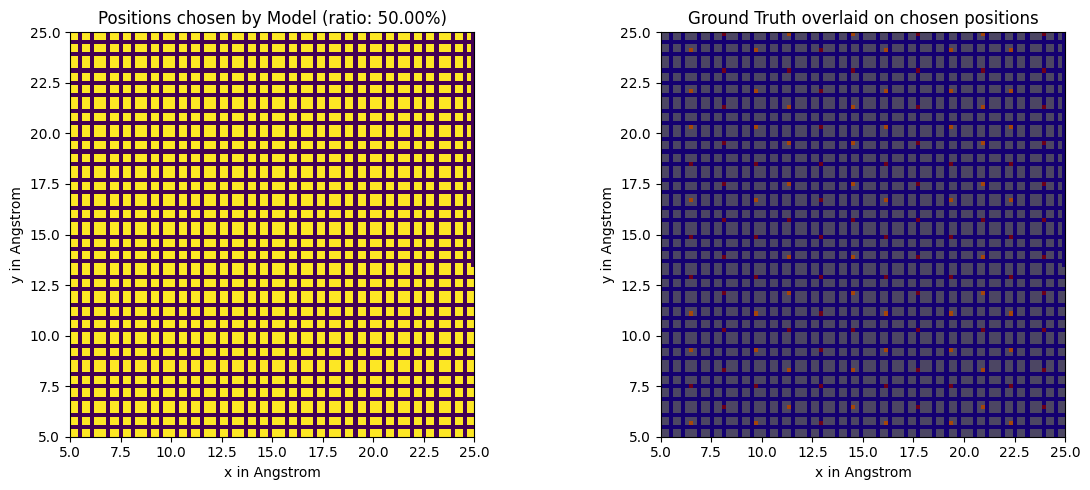

Number of positions scanned: 5000
Number of positions with atoms in them in ground truth: 132
Median number of scans per atom: 2.36
Ratio of scans (suggested + initial) that are close to an atom position: 6.24%


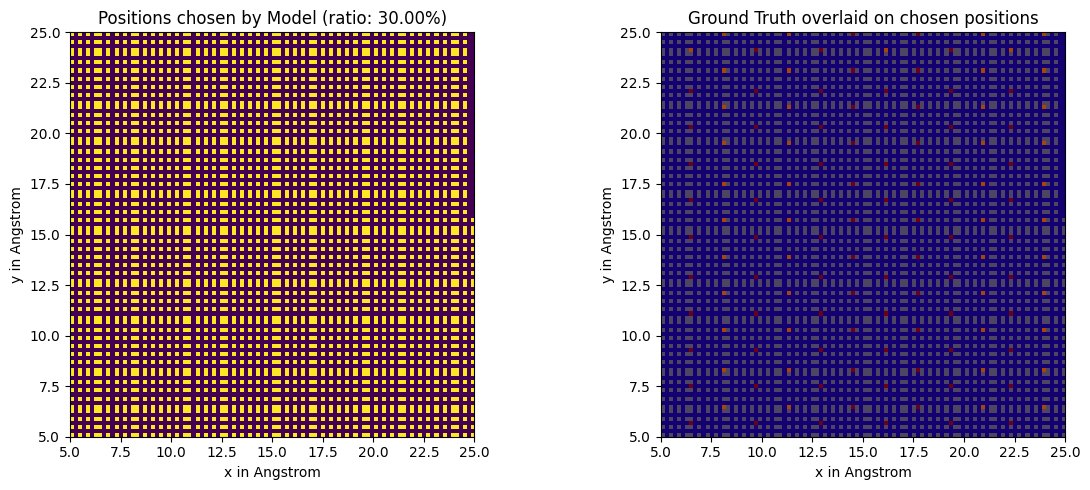

Number of positions scanned: 3000
Number of positions with atoms in them in ground truth: 132
Median number of scans per atom: 1.51
Ratio of scans (suggested + initial) that are close to an atom position: 6.63%


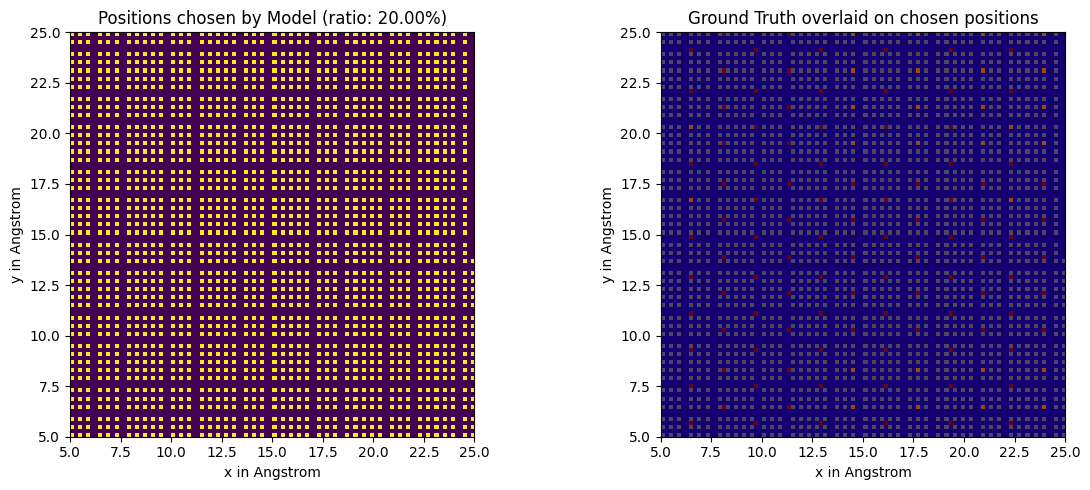

Number of positions scanned: 2000
Number of positions with atoms in them in ground truth: 132
Median number of scans per atom: 0.94
Ratio of scans (suggested + initial) that are close to an atom position: 6.20%


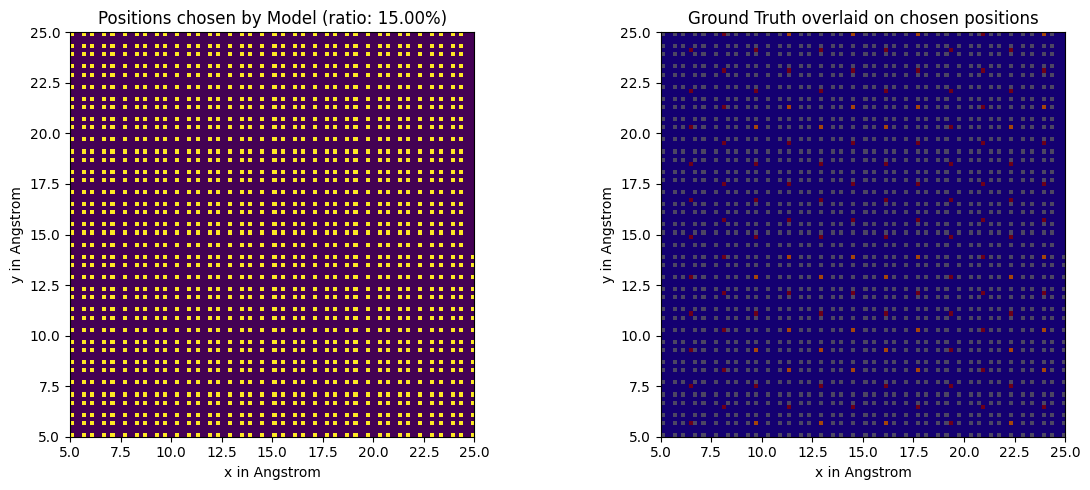

Number of positions scanned: 1500
Number of positions with atoms in them in ground truth: 132
Median number of scans per atom: 0.92
Ratio of scans (suggested + initial) that are close to an atom position: 8.13%


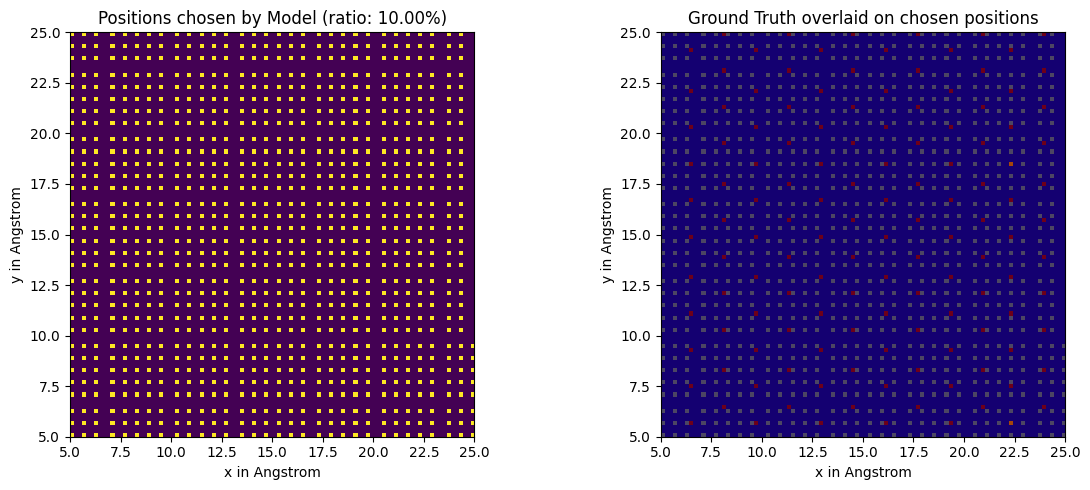

Number of positions scanned: 1000
Number of positions with atoms in them in ground truth: 132
Median number of scans per atom: 0.34
Ratio of scans (suggested + initial) that are close to an atom position: 4.50%


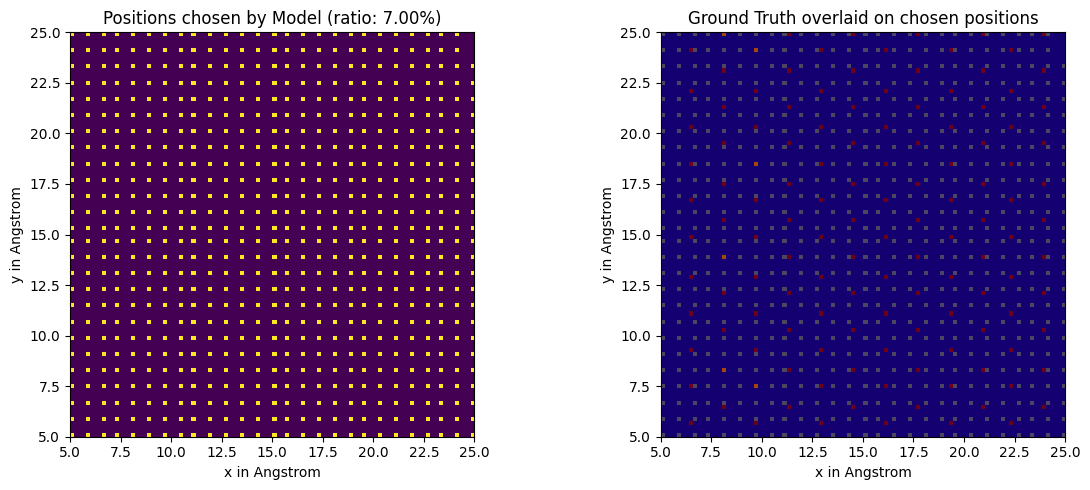

Number of positions scanned: 700
Number of positions with atoms in them in ground truth: 132
Median number of scans per atom: 0.29
Ratio of scans (suggested + initial) that are close to an atom position: 5.43%


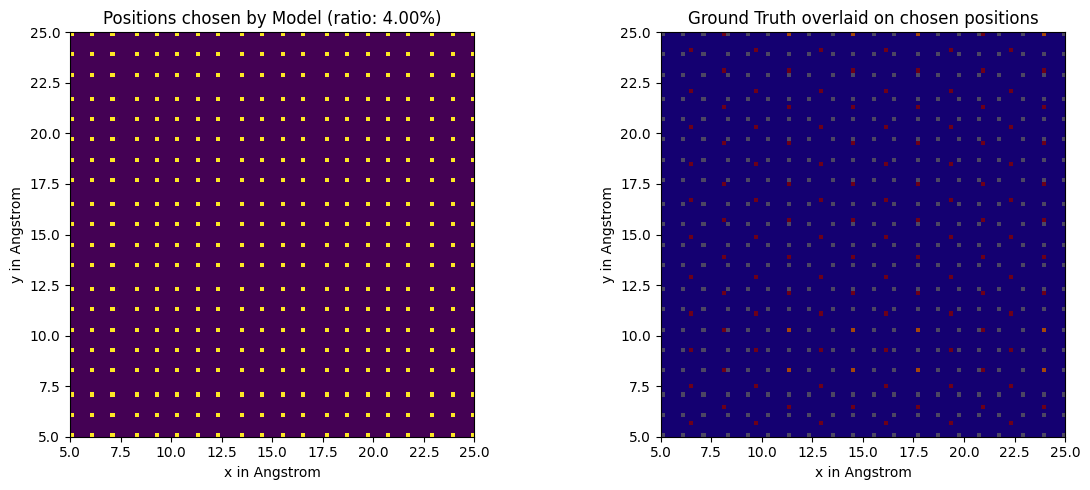

Number of positions scanned: 400
Number of positions with atoms in them in ground truth: 132
Median number of scans per atom: 0.29
Ratio of scans (suggested + initial) that are close to an atom position: 9.50%


In [255]:
median_scans_per_atom_evenly_spaced = []
useful_scans_evenly_spaced = []
std_scans_per_atom_evenly_spaced = []
scans_per_atom_evenly_spaced = []

for ratioPos in numberOfPositions:
    evenlySpacedIndices = generate_even_grid(Predictions.shape, int(np.prod(Predictions.shape)*ratioPos))

    numberOfPredictions = len(evenlySpacedIndices)
    Position_Mask = np.zeros_like(groundTruth)

    for x, y in allCoords:
        # Check if the position is chosen as an intial position or in the top predictions
        # Here we use the 3th sparse grid
        if (x,y) in evenlySpacedIndices:
            Position_Mask[x,y] = 1

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    # Plot Predictions
    im1 = axes[0].imshow(Position_Mask.T, origin="lower", interpolation="none", extent=extent)
    axes[0].set_title(f"Positions chosen by Model (ratio: {ratioPos*100:.2f}%)")
    axes[0].set_xlabel("x in Angstrom")
    axes[0].set_ylabel("y in Angstrom")
    # Plot Ground Truth
    im2 = axes[1].imshow(Position_Mask.T, origin="lower", interpolation="none", extent=extent, alpha=1)
    axes[1].imshow(groundTruth.T, "jet",origin="lower", interpolation="none", extent=extent, alpha=0.7)
    axes[1].set_title("Ground Truth overlaid on chosen positions")
    plt.xlabel("x in Angstrom")
    plt.ylabel("y in Angstrom")
    plt.tight_layout()
    plt.show()
    number_of_scans_per_atom = []
    close_Coords_multiple = set()
    for x, y in allCoords:
        if groundTruth[x,y] > 0:
            number_of_scans_per_atom.append(0)
            for xCircle in range(-acceptable_distance,acceptable_distance+1):
                for yCircle in range(-acceptable_distance,acceptable_distance+1):
                    if xCircle**2 + yCircle**2 > acceptable_distance**2:
                        continue
                    currentX = x+xCircle
                    currentY = y+yCircle
                    if currentX < 0 or currentX >= Predictions.shape[0] or currentY < 0 or currentY >= Predictions.shape[1]:
                        #skip if the predicted position is outside the sample
                        continue
                    if ((currentX,currentY) in evenlySpacedIndices) :
                        number_of_scans_per_atom[-1] += 1
    for x, y in evenlySpacedIndices:
        for xCircle in range(-acceptable_distance,acceptable_distance+1):
            for yCircle in range(-acceptable_distance,acceptable_distance+1):
                if xCircle**2 + yCircle**2 > acceptable_distance**2:
                        continue
                currentX = x+xCircle
                currentY = y+yCircle
                if currentX < 0 or currentX >= Predictions.shape[0] or currentY < 0 or currentY >= Predictions.shape[1]:
                    #skip if the predicted position is outside the sample
                    continue
                if groundTruth[currentX,currentY] > 0:
                    close_Coords_multiple.add((x,y))
    median_scans_per_atom = np.mean(number_of_scans_per_atom)
    std_scans_per_atom = np.std(number_of_scans_per_atom) if number_of_scans_per_atom else 0
    useful_scans = 100* len(close_Coords_multiple) / numberOfPredictions
    median_scans_per_atom_evenly_spaced.append(median_scans_per_atom)
    useful_scans_evenly_spaced.append(useful_scans)
    std_scans_per_atom_evenly_spaced.append(std_scans_per_atom)
    scans_per_atom_evenly_spaced.append(number_of_scans_per_atom)

    print(f"Number of positions scanned: {numberOfPredictions}")
    print(f"Number of positions with atoms in them in ground truth: {np.sum(groundTruth > 0)}")
    print(f"Median number of scans per atom: {median_scans_per_atom:.2f}")
    print(f"Ratio of scans (suggested + initial) that are close to an atom position: {useful_scans:.2f}%")

The model clearly recognizes where atoms lie and therefore the scans are more useful when reconstructing the specimen later. As earlier work by M. Schloz et al. has shown the most information lies in scan that are on atoms. As a rough approximation we again count scans that are close (+/- 1 scan position) to an atom as useful. By dividing this by the total number of scans we get a ratio that shows us how many useful positions where scanned.

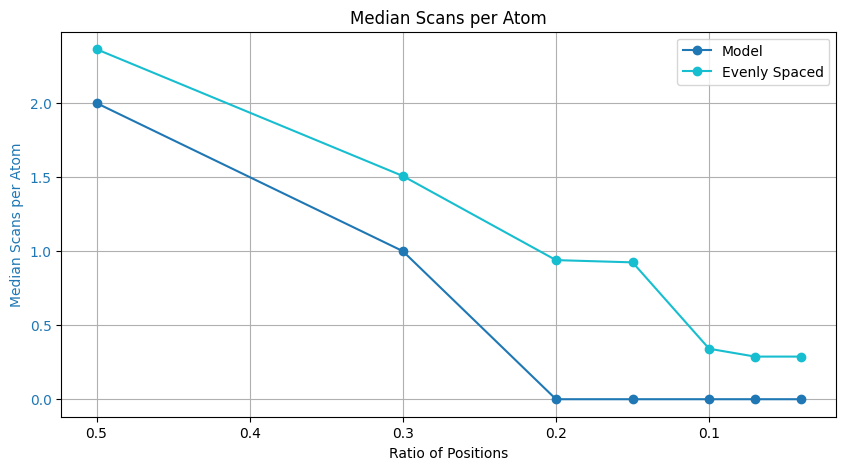

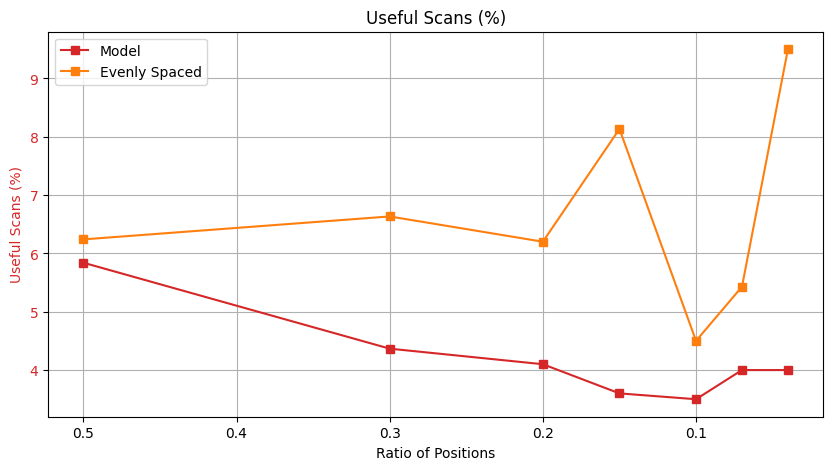

In [256]:
fig, ax1 = plt.subplots(figsize=(10, 5))
color1 = 'tab:blue'
ax1.set_xlabel('Ratio of Positions')
ax1.set_ylabel('Median Scans per Atom', color=color1)
ax1.plot(numberOfPositions, median_scans_per_atom_with_model, marker='o', label='Model', color=color1)
ax1.plot(numberOfPositions, median_scans_per_atom_evenly_spaced, marker='o', label='Evenly Spaced', color='tab:cyan')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.invert_xaxis()
ax1.set_title('Median Scans per Atom')
ax1.legend()
ax1.grid()
plt.show()

fig, ax2 = plt.subplots(figsize=(10, 5))
color2 = 'tab:red'
ax2.set_xlabel('Ratio of Positions')
ax2.set_ylabel('Useful Scans (%)', color=color2)
ax2.plot(numberOfPositions, useful_scans_with_model, marker='s', label='Model', color=color2)
ax2.plot(numberOfPositions, useful_scans_evenly_spaced, marker='s', label='Evenly Spaced', color='tab:orange')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.invert_xaxis()
ax2.set_title('Useful Scans (%)')
ax2.legend()
ax2.grid()
plt.show()

We can see that with lower ratios the model is performing a lot better than just using a evenly spaced grid.

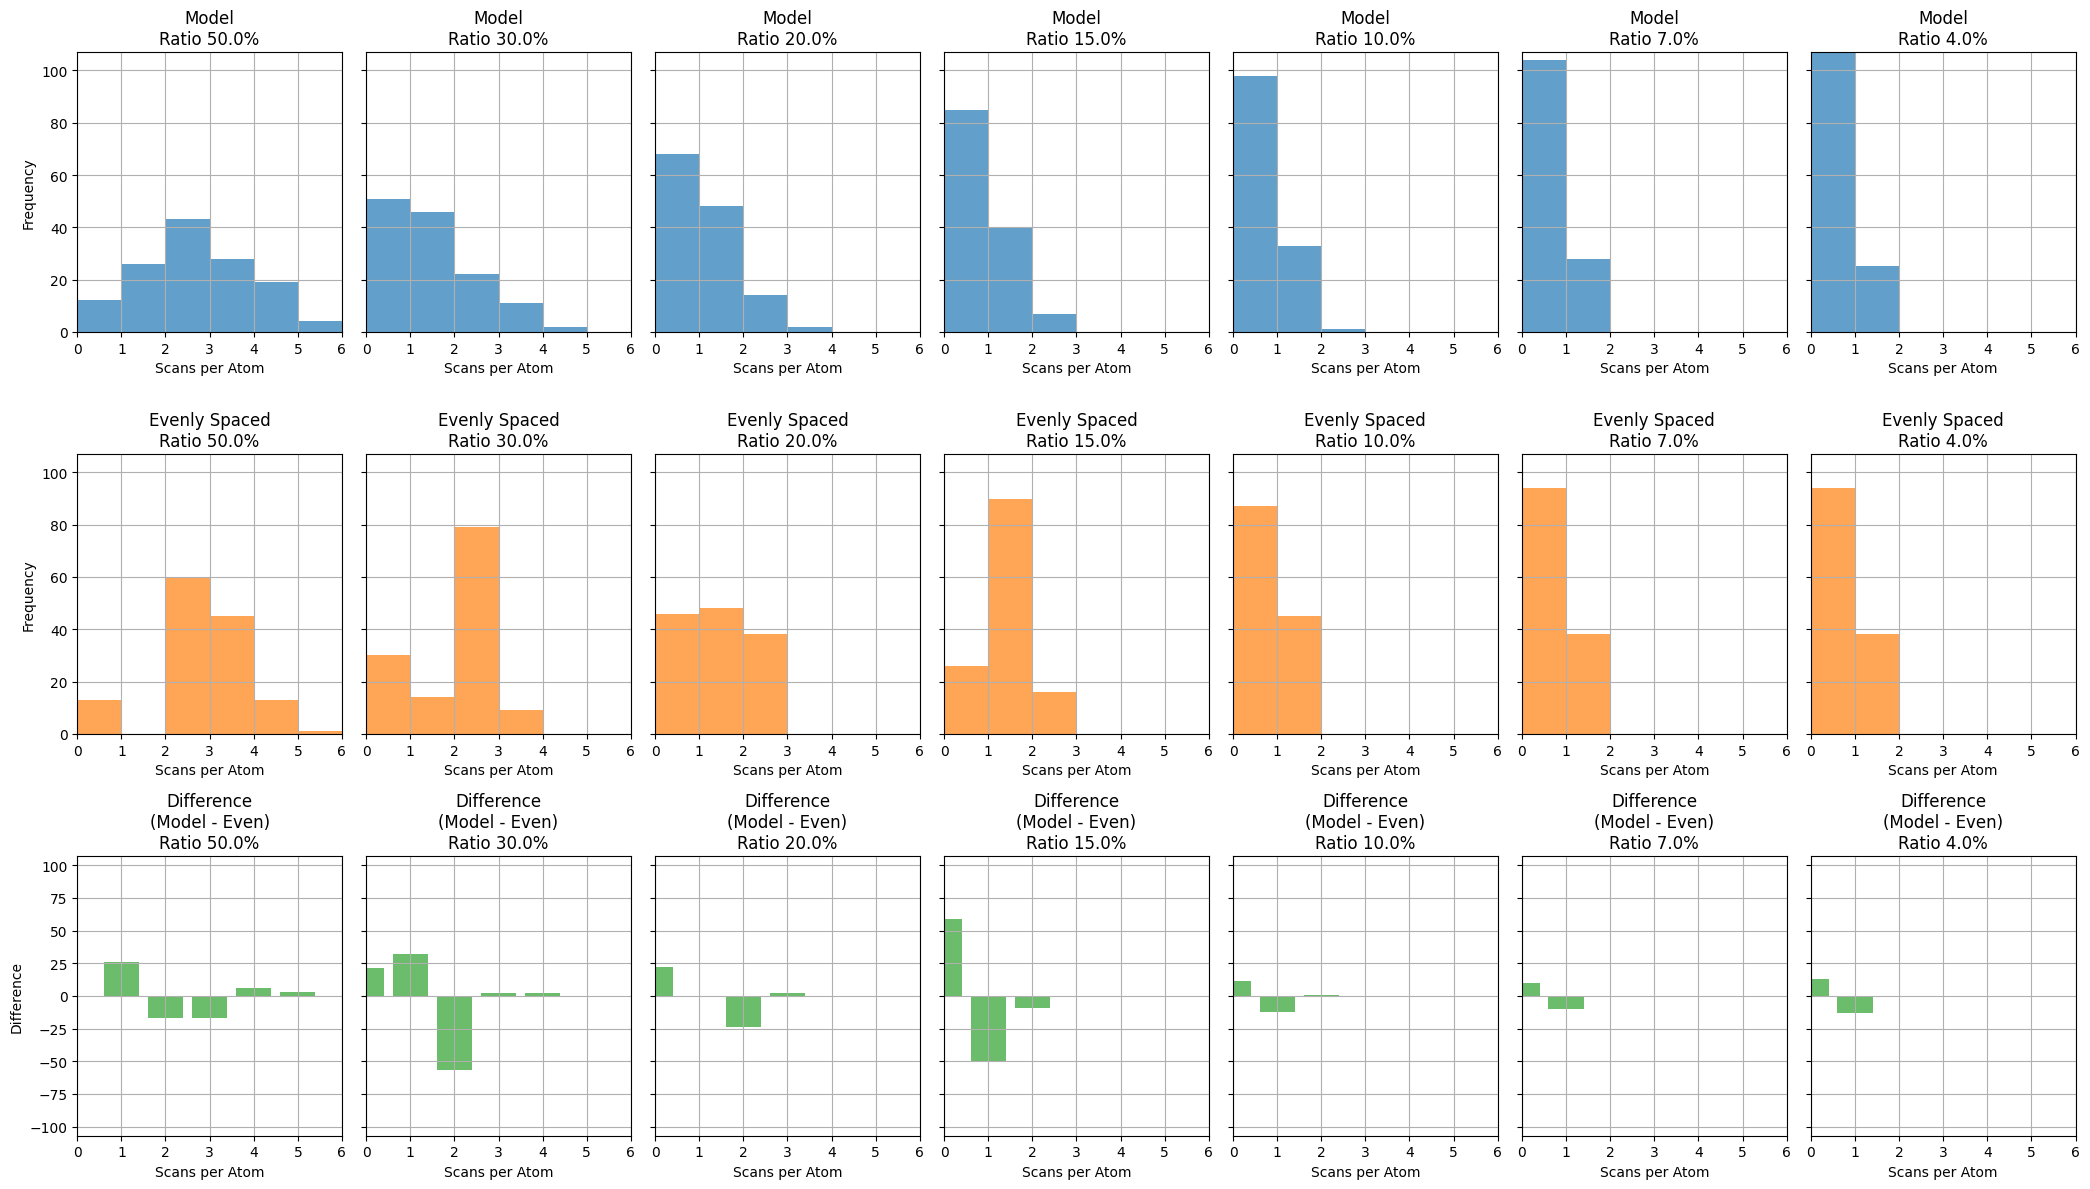

In [257]:
# Find global min and max for x-axis (scans per atom)
all_scans = [scan for scans in scans_per_atom_with_model + scans_per_atom_evenly_spaced for scan in scans]
xmin = min(all_scans)
xmax = max(all_scans)
bins = range(xmin, xmax + 2)  # +2 to include the last value

# Find global max for y-axis
all_counts = []
for scans in scans_per_atom_with_model + scans_per_atom_evenly_spaced:
    counts, _ = np.histogram(scans, bins=bins)
    all_counts.append(counts)
ymax = max([c.max() for c in all_counts])

fig, axes = plt.subplots(3, len(numberOfPositions), figsize=(3 * len(numberOfPositions), 12), sharey='row')

# Model-based scans
for i, scans in enumerate(scans_per_atom_with_model):
    axes[0, i].hist(scans, bins=bins, alpha=0.7, color='tab:blue')
    axes[0, i].set_title(f'Model\nRatio {numberOfPositions[i]*100:.1f}%')
    axes[0, i].set_xlabel('Scans per Atom')
    axes[0, i].set_xlim(xmin, xmax + 1)
    axes[0, i].set_ylim(0, ymax)
    if i == 0:
        axes[0, i].set_ylabel('Frequency')
    axes[0, i].grid()

# Evenly spaced scans
for i, scans in enumerate(scans_per_atom_evenly_spaced):
    axes[1, i].hist(scans, bins=bins, alpha=0.7, color='tab:orange')
    axes[1, i].set_title(f'Evenly Spaced\nRatio {numberOfPositions[i]*100:.1f}%')
    axes[1, i].set_xlabel('Scans per Atom')
    axes[1, i].set_xlim(xmin, xmax + 1)
    axes[1, i].set_ylim(0, ymax)
    if i == 0:
        axes[1, i].set_ylabel('Frequency')
    axes[1, i].grid()

# Difference plot (model - evenly spaced)
for i, (scans_model, scans_even) in enumerate(zip(scans_per_atom_with_model, scans_per_atom_evenly_spaced)):
    counts_model, _ = np.histogram(scans_model, bins=bins)
    counts_even, _ = np.histogram(scans_even, bins=bins)
    diff = counts_model - counts_even
    axes[2, i].bar(bins[:-1], diff, width=0.8, color='tab:green', alpha=0.7)
    axes[2, i].set_title(f'Difference\n(Model - Even)\nRatio {numberOfPositions[i]*100:.1f}%')
    axes[2, i].set_xlabel('Scans per Atom')
    axes[2, i].set_xlim(xmin, xmax + 1)
    axes[2, i].set_ylim(-ymax, ymax)
    if i == 0:
        axes[2, i].set_ylabel('Difference')
    axes[2, i].grid()

plt.tight_layout()
plt.show()
